<p style="font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 10px 100px;">Solution to Facial Recognition System using a SVM Model</p>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import errno
import cv2
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import tensorflow as tf
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Copying Dataset

In [2]:
# This is a function for copying files or directories from 'src' to 'dest'.
def copy(src, dest):
    try:
        # shutil.copytree copies an entire directory tree, including all subdirectories.
        shutil.copytree(src, dest)
    except OSError as e:
        # errno.ENOTDIR means the source is a file and not a directory.
        if e.errno == errno.ENOTDIR:
            # shutil.copy copies a file from 'src' to 'dest'.
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)

# Specify the source and destination paths for the dataset.            
src = '../input/lfwpeople'
dest = '../LFW/lfw4/lfw_home'
# Use the copy function to copy the files from source to destination.
copy(src,dest)
# Print the list of files in the source and destination directories.
print(os.listdir('../input/lfwpeople'))
print(os.listdir('../LFW/lfw4/lfw_home'))

['pairsDevTrain.txt', 'lfw-funneled.tgz', 'pairsDevTest.txt', 'pairs.txt']
['pairs.txt', 'pairsDevTest.txt', 'lfw-funneled.tgz', 'pairsDevTrain.txt']


# Loading Dataset

In [3]:
# Specify the path to the dataset.
path = '../LFW/lfw4/'
print("Fetching LFW people dataset from:", path)

# Fetch the dataset from the specified path and only download the images of people with 80 or more faces.
lfw_dataset = sklearn.datasets.fetch_lfw_people(data_home = path, min_faces_per_person=80,  download_if_missing = False)

n_samples, h, w = lfw_dataset.images.shape
print("Fetched dataset with", n_samples, "samples")
# Set the seed for the numpy random number generator, which is used for creating random splits of the data for training and testing.
np.random.seed(42)
# Assign the image data to 'X'.
X = lfw_dataset.data
# Get the number of features in the dataset, which in this case would be the height of the images.
n_features = X.shape[1]

# Assign the target values to 'y'.
y = lfw_dataset.target
target_names = lfw_dataset.target_names
# Get the number of classes in the dataset.
n_classes = target_names.shape[0]

Fetching LFW people dataset from: ../LFW/lfw4/
Fetched dataset with 1140 samples


# Data Exploration

In [4]:
# Print out details regarding the dataset.
print(f"Number of images: {n_samples}")
print(f"Number of classes: {n_classes}")
print(f"Image shape: {h} x {w}")

Number of images: 1140
Number of classes: 5
Image shape: 62 x 47


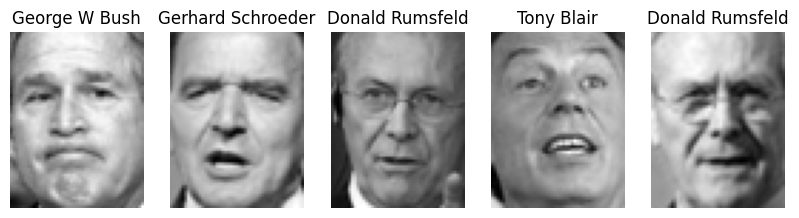

In [5]:
# Create a new figure to display images with a size of (10, 5).
plt.figure(figsize=(10, 5))
# Loop to display the first five images in the dataset.
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i].reshape((h, w)), cmap='gray')
    plt.title(target_names[y[i]])
    plt.axis('off')
plt.show()

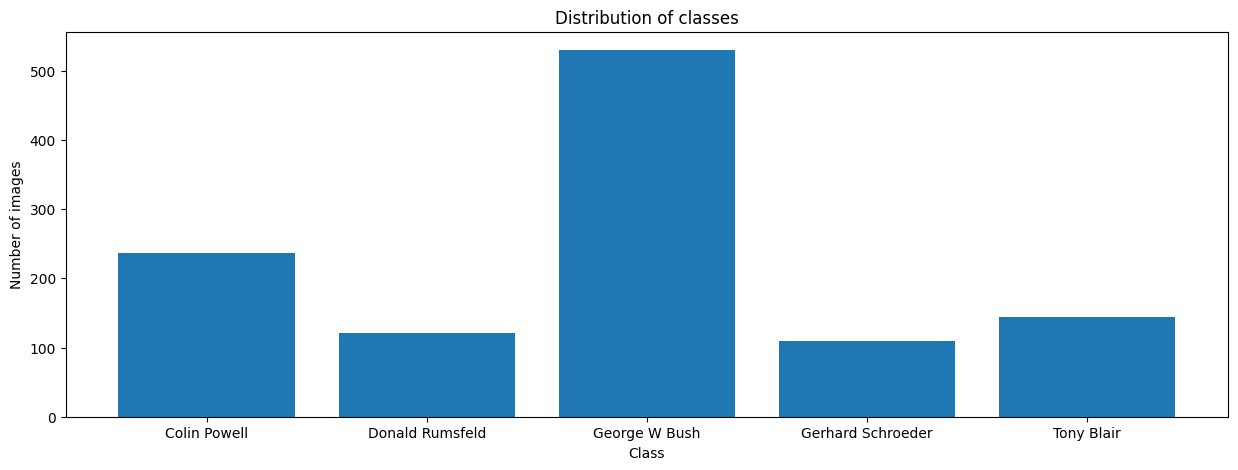

In [6]:
# Create a bar chart to visualise the amount of images for each class.
label, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(15, 5))
plt.bar(target_names[label], counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Distribution of classes')
plt.show()

# Data Splitting

In [7]:
# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Applying PCA

In [8]:
# Set the number of components for further analysis after applying PCA.
n_components = 200
# Print the number of components and training examples.
print(f"Extracting the top {n_components} eigenfaces from {X_train.shape[0]} faces")

# Fit a PCA (Principal Component Analysis) model to the training data.
# The model will keep the top 200 components based on their significance.
# PCA is used here to reduce the dimensionality of the data and keep only significant features.
# svd_solver='randomized' is efficient for large datasets.
# whiten=True can help the model perform better as it transforms the data to have a mean of 0 and variance of 1.
pca = PCA(n_components=n_components, svd_solver='randomized',whiten=True).fit(X_train)

# Reshapes the components to have the same shape as the images.
eigenfaces = pca.components_.reshape((n_components, h, w))

# Transform the training and testing data by applying the PCA transformation.
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Extracting the top 200 eigenfaces from 855 faces


# Fitting Model

In [9]:
print("Fitting the classifier to the training set...")
# Create a parameter grid to be used for a grid search. The grid search will find the best parameters for the SVM classifier from the given options.
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

# Initialize an SVM classifier and perform a grid search with cross-validation to find the best parameters.
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
# Fit the classifier to the training data.
clf = clf.fit(X_train_pca, y_train)

# Get the results of the grid search.
cv_results = clf.cv_results_

# Print the best parameters found by the grid search.
print("Best parameters found by grid search:")
print(clf.best_params_)

Fitting the classifier to the training set...
Best parameters found by grid search:
{'C': 1000.0, 'gamma': 0.001}


# Evaluation

In [10]:
# Predict the labels for the testing data.
y_pred = clf.predict(X_test_pca)

# Print the classification report for the predictions on the test set.
print("Predicting people's names on the test set")
print(classification_report(y_test, y_pred, target_names=target_names))

Predicting people's names on the test set
                   precision    recall  f1-score   support

     Colin Powell       0.89      0.88      0.88        64
  Donald Rumsfeld       0.88      0.88      0.88        32
    George W Bush       0.88      0.92      0.90       127
Gerhard Schroeder       0.93      0.86      0.89        29
       Tony Blair       0.90      0.82      0.86        33

         accuracy                           0.89       285
        macro avg       0.89      0.87      0.88       285
     weighted avg       0.89      0.89      0.89       285



In [11]:
# Print the confusion matrix for the predictions on the test set.
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[ 56   1   5   1   1]
 [  0  28   2   1   1]
 [  7   3 117   0   0]
 [  0   0   3  25   1]
 [  0   0   6   0  27]]
